In [ ]:
# ============================================================
# 0) INSTALLS (once per runtime)
# ============================================================
!pip install -q torch torchvision transformers accelerate scikit-learn seaborn


In [ ]:
# ============================================================
# 1) IMPORTS + SEED
# ============================================================
import os
import json
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms
from PIL import Image

from transformers import (
    AutoImageProcessor,
    ConvNextForImageClassification,
    Trainer,
    TrainingArguments,
    EvalPrediction,
)

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

# reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Seed fixed at 42")


✅ Seed fixed at 42


In [ ]:
# ============================================================
# 2) PATH SETUP (Drive + preprocessed + outputs)
# ============================================================
drive.mount('/content/drive')

PREPROC_ROOT = "/content/drive/MyDrive/MultiBanFake/preprocessed"
OUTPUT_ROOT  = "/content/drive/MyDrive/MultiBanFake/outputs_convnext_large"
os.makedirs(PREPROC_ROOT, exist_ok=True)
os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("PREPROC_ROOT:", PREPROC_ROOT)
print("OUTPUT_ROOT :", OUTPUT_ROOT)


Mounted at /content/drive
PREPROC_ROOT: /content/drive/MyDrive/MultiBanFake/preprocessed
OUTPUT_ROOT : /content/drive/MyDrive/MultiBanFake/outputs_convnext_large


In [ ]:
# ============================================================
# 3) LOAD PREPROCESSED DATA (NPZ)
# ============================================================
train_npz = np.load(os.path.join(PREPROC_ROOT, "train_npz.npz"))
val_npz   = np.load(os.path.join(PREPROC_ROOT, "val_npz.npz"))
test_npz  = np.load(os.path.join(PREPROC_ROOT, "test_npz.npz"))

with open(os.path.join(PREPROC_ROOT, "classes.json"), "r") as f:
    classes = json.load(f)

print("Train images:", train_npz["images"].shape, "labels:", train_npz["labels"].shape)
print("Val images  :", val_npz["images"].shape,   "labels:", val_npz["labels"].shape)
print("Test images :", test_npz["images"].shape,  "labels:", test_npz["labels"].shape)
print("Classes:", classes)

num_labels = len(classes)
label_names = classes
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {i: name for name, i in label2id.items()}


Train images: (7603, 224, 224, 3) labels: (7603,)
Val images  : (957, 224, 224, 3) labels: (957,)
Test images : (957, 224, 224, 3) labels: (957,)
Classes: ['Fake', 'Real']


In [ ]:
# ============================================================
# 4) DATASET CLASS (numpy cache + transforms)
# ============================================================
class CachedImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images    # [N, H, W, C], uint8
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]
        lbl = int(self.labels[idx])

        img = Image.fromarray(img)  # numpy -> PIL
        if self.transform:
            img = self.transform(img)

        return {
            "pixel_values": img,
            "labels": torch.tensor(lbl, dtype=torch.long)
        }


In [ ]:
# ============================================================
# 5) TRANSFORMS (ConvNeXt-friendly, use processor.size/mean/std)
# ============================================================
MODEL_NAME = "facebook/convnext-large-224-22k-1k"

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

# কিছু মডেলে size dict, কিছুতে int
size_conf = processor.size
if isinstance(size_conf, dict):
    img_size = size_conf.get("shortest_edge") or size_conf.get("height") or 224
else:
    img_size = size_conf
print("Using image size:", img_size)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

train_ds = CachedImageDataset(
    images=train_npz["images"],
    labels=train_npz["labels"],
    transform=train_transform,
)
val_ds = CachedImageDataset(
    images=val_npz["images"],
    labels=val_npz["labels"],
    transform=eval_transform,
)
test_ds = CachedImageDataset(
    images=test_npz["images"],
    labels=test_npz["labels"],
    transform=eval_transform,
)

print("Train dataset size:", len(train_ds))
print("Val dataset size  :", len(val_ds))
print("Test dataset size :", len(test_ds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using image size: 224
Train dataset size: 7603
Val dataset size  : 957
Test dataset size : 957


In [ ]:
# ============================================================
# 6) CLASS WEIGHTS + SAMPLE WEIGHTS (imbalance handling)
# ============================================================
train_labels = train_npz["labels"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels,
)
print("Class weights:", class_weights)

sample_weights = np.array([class_weights[label] for label in train_labels], dtype=np.float64)
sample_weights_torch = torch.from_numpy(sample_weights)
print("Sample weights shape:", sample_weights_torch.shape)

Class weights: [1.00224097 0.99776903]
Sample weights shape: torch.Size([7603])


In [ ]:
# ============================================================
# 7) ConvNeXt MODEL LOAD
# ============================================================
convnext_model = ConvNextForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 22k head -> 2-class head
)

print("Loaded ConvNeXt model:", MODEL_NAME)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/791M [00:00<?, ?B/s]

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-large-224-22k-1k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1536]) in the checkpoint and torch.Size([2, 1536]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded ConvNeXt model: facebook/convnext-large-224-22k-1k


In [ ]:
# ============================================================
# 8) METRICS
# ============================================================
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1_weighted = f1_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1_weighted": f1_weighted,
    }

In [ ]:
# ============================================================
# 9) CUSTOM TRAINER (class-weight + sampler + label smoothing)
# ============================================================
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, sample_weights=None, **kwargs):
        super().__init__(*args, **kwargs)

        if class_weights is not None:
            if isinstance(class_weights, torch.Tensor):
                self.class_weights = class_weights.detach().clone().float()
            else:
                self.class_weights = torch.tensor(class_weights, dtype=torch.float)
        else:
            self.class_weights = None

        if sample_weights is not None:
            if isinstance(sample_weights, torch.Tensor):
                self.sample_weights = sample_weights.detach().clone().double()
            else:
                self.sample_weights = torch.tensor(sample_weights, dtype=torch.double)
        else:
            self.sample_weights = None

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: int | None = None,
    ):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)
        else:
            loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)

        loss = loss_fct(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

    def get_train_dataloader(self):
        if self.sample_weights is None:
            return super().get_train_dataloader()

        if isinstance(self.train_dataset, torch.utils.data.IterableDataset):
            return super().get_train_dataloader()

        sampler = WeightedRandomSampler(
            weights=self.sample_weights,
            num_samples=len(self.sample_weights),
            replacement=True,
        )

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )


In [ ]:
# ============================================================
# 10) TRAINING ARGUMENTS
# ============================================================
output_dir = os.path.join(OUTPUT_ROOT, "convnext_model_full")
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=3e-5,
    weight_decay=0.01,

    eval_steps=500,
    save_steps=500,
    logging_steps=50,

    fp16=True,
    save_total_limit=2,
    remove_unused_columns=False,
)

print("TrainingArguments ready.")

model.safetensors:   0%|          | 0.00/791M [00:00<?, ?B/s]

TrainingArguments ready.


15a26bfde02e39ba547185222150f57c5c5d8e02

In [ ]:
# ============================================================
# 11) TRAIN ConvNeXt
# ============================================================
trainer = CustomTrainer(
    model=convnext_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    sample_weights=sample_weights_torch,
)

trainer.train()

# ---- SAVE BEST MODEL ----
best_model_dir = os.path.join(OUTPUT_ROOT, "convnext_large_best_model")
os.makedirs(best_model_dir, exist_ok=True)
trainer.save_model(best_model_dir)

print("✅ Saved best ConvNeXt model to:", best_model_dir)


Step,Training Loss
50,0.794000
100,0.727400
150,0.728500
200,0.666700
250,0.631800
300,0.629100
350,0.609100
400,0.613500
450,0.578800
500,0.594600


✅ Saved best ConvNeXt model to: /content/drive/MyDrive/MultiBanFake/outputs_convnext_large/convnext_large_best_model



📊 Classification Report (ConvNeXt):

              precision    recall  f1-score   support

        Fake     0.6343    0.5744    0.6029       477
        Real     0.6133    0.6708    0.6408       480

    accuracy                         0.6228       957
   macro avg     0.6238    0.6226    0.6218       957
weighted avg     0.6238    0.6228    0.6219       957



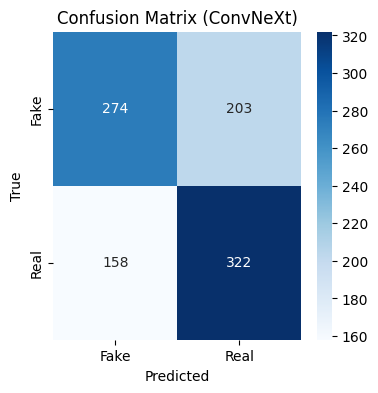

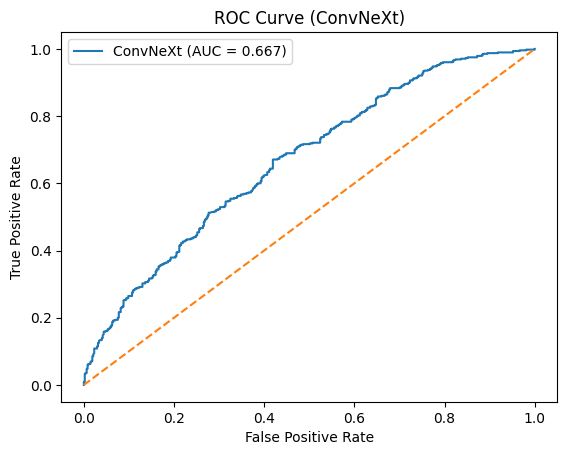


✅ Saved ConvNeXt report to: /content/drive/MyDrive/MultiBanFake/outputs_convnext_large/convnext_classification_report_full.json
✅ Saved ConvNeXt probs(json) to: /content/drive/MyDrive/MultiBanFake/outputs_convnext_large/convnext_stack_probs_full.json


In [ ]:
# ============================================================
# 12) EVAL ON TEST + REPORT + CONFUSION + ROC + PROBS(JSON)
# ============================================================
convnext_preds = trainer.predict(test_ds)
logits = convnext_preds.predictions
convnext_pred_labels = np.argmax(logits, axis=-1)
convnext_true_labels = convnext_preds.label_ids

print("\n📊 Classification Report (ConvNeXt):\n")
print(classification_report(
    convnext_true_labels,
    convnext_pred_labels,
    target_names=label_names,
    digits=4
))

cm = confusion_matrix(convnext_true_labels, convnext_pred_labels)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (ConvNeXt)")
plt.show()

if num_labels == 2:
    convnext_probs_arr = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    fpr, tpr, _ = roc_curve(convnext_true_labels, convnext_probs_arr[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ConvNeXt (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (ConvNeXt)")
    plt.legend()
    plt.show()
else:
    convnext_probs_arr = torch.softmax(torch.tensor(logits), dim=-1).numpy()

convnext_report_dict = classification_report(
    convnext_true_labels,
    convnext_pred_labels,
    target_names=label_names,
    digits=4,
    output_dict=True,
)

convnext_report_path = os.path.join(OUTPUT_ROOT, "convnext_classification_report_full.json")
convnext_probs_json_path  = os.path.join(OUTPUT_ROOT, "convnext_stack_probs_full.json")

with open(convnext_report_path, "w") as f:
    json.dump(convnext_report_dict, f, indent=4)

convnext_probs_list = convnext_probs_arr.tolist()
with open(convnext_probs_json_path, "w") as f:
    json.dump({
        "convnext_probs": convnext_probs_list,
        "true_labels": convnext_true_labels.tolist()
    }, f)

print("\n✅ Saved ConvNeXt report to:", convnext_report_path)
print("✅ Saved ConvNeXt probs(json) to:", convnext_probs_json_path)


In [ ]:
# ============================================================
# 13) SOFTMAX PROBS (VAL + TEST) → .NPY FOR ENSEMBLE
# ============================================================
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

best_model_path = best_model_dir

convnext_best = ConvNextForImageClassification.from_pretrained(
    best_model_path
).to(device)
convnext_best.eval()

print("Loaded ConvNeXt best model for softmax extraction!")

@torch.no_grad()
def get_softmax_probs(model, dataloader, device):
    all_probs = []
    all_labels = []

    model.eval()

    for batch in dataloader:
        imgs = batch["pixel_values"].to(device)
        labels = batch["labels"].cpu().numpy()

        outputs = model(imgs)
        logits = outputs.logits
        probs = F.softmax(logits, dim=-1).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels)

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_probs, all_labels

val_loader  = DataLoader(val_ds,  batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

val_probs, val_labels = get_softmax_probs(convnext_best, val_loader, device)
test_probs, test_labels = get_softmax_probs(convnext_best, test_loader, device)

print("Softmax shapes (val, test):", val_probs.shape, test_probs.shape)

SAVE_DIR = "/content/drive/MyDrive/MultiBanFake/convnext_large_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "val_probs.npy"),  val_probs)
np.save(os.path.join(SAVE_DIR, "val_labels.npy"), val_labels)
np.save(os.path.join(SAVE_DIR, "test_probs.npy"), test_probs)
np.save(os.path.join(SAVE_DIR, "test_labels.npy"), test_labels)

print("✅ Saved ConvNeXt softmax probs to:", SAVE_DIR)

Loaded ConvNeXt best model for softmax extraction!
Softmax shapes (val, test): (957, 2) (957, 2)
✅ Saved ConvNeXt softmax probs to: /content/drive/MyDrive/MultiBanFake/convnext_outputs
